# Case Study: BioPharma

### Importing Required Libraries

In [1]:
import pandas as pd  
import pulp
import numpy as np

### Reading and Entering the Input Data

#### Table 6-18: Sales (Demand)

In [2]:
data_demand = pd.read_excel('RSM_2405-SCM_2024-Biopharma Model.xlsx', skiprows = 5, nrows=7,  usecols= 'A:C')
data_demand.rename(columns={"Unnamed: 0": "Market"}, inplace=True)
display(data_demand)

,Market,Highcal,Relax
0,Latin America,7,7
1,Europe,15,12
2,Asia w/o Japan,5,3
3,Japan,7,8
4,Mexico,3,3
5,U.S.,18,17


#### Table 6-18: Capacity

In [3]:
data_capacity = pd.read_excel('RSM_2405-SCM_2024-Biopharma Model.xlsx', skiprows = 4, nrows=7,  usecols= 'D:E')
data_capacity = data_capacity.iloc[1:]
display(data_capacity)

,Plant,Capacity
1,Brazil,18.0
2,Germany,45.0
3,India,18.0
4,Japan,10.0
5,Mexico,30.0
6,U.S.,22.0


#### Table 6-19: Fixed and Variable Procution Cost in 2013 (US $)

In [4]:
data_fixed_variable_cost = pd.read_excel('RSM_2405-SCM_2024-Biopharma Model.xlsx', skiprows = 22, nrows=7,  usecols= 'A:H')
display(data_fixed_variable_cost)

,Plant,Plant Fixed Cost (Million $),Highcal Fixed Cost (Million $),Relax Fixed Cost (Million $),Highcal Raw Material Cost ($/kg),Highcal Production Cost ($/kg),Relax Raw Material Cost ($/kg),Relax Production Cost ($/kg)
0,Brazil,20,5,5,3.6,5.1,4.6,6.6
1,Germany,45,13,13,3.9,6.0,5.0,7.0
2,India,14,3,3,3.6,4.5,4.5,6.0
3,Japan,13,4,4,3.9,6.0,5.1,7.0
4,Mexico,30,6,6,3.6,5.0,4.6,6.5
5,U.S.,23,5,5,3.6,5.0,4.5,6.5


#### Table 6-20: Transporation Costs from Plants to Markets (US $/kg)

In [5]:
data_transportation_cost = pd.read_excel('RSM_2405-SCM_2024-Biopharma Model.xlsx', skiprows = 83, nrows=7,  usecols= 'A:G')
display(data_transportation_cost)

,From / To,Latin America,Europe,Asia w/o Japan,Japan,Mexico,U.S.
0,Brazil,0.20,0.45,0.50,0.50,0.40,0.45
1,Germany,0.45,0.20,0.35,0.40,0.30,0.30
2,India,0.50,0.35,0.20,0.30,0.50,0.45
3,Japan,0.50,0.40,0.30,0.10,0.45,0.45
4,Mexico,0.40,0.30,0.50,0.45,0.20,0.25
5,U.S.,0.45,0.30,0.45,0.45,0.25,0.20


#### Table 6-21 History of Exhange Rates

In [6]:
data = {'Currency': ['Brazilian Real', 'Euro', 'Indian Rupee', 'Japanese Yen', 'Mexican Peso', 'U.S. Dollar'],
       '2013': [2.15, 0.75, 58.44, 97.58, 12.75, 1],
       '2012': [1.95, 0.78, 53.46, 79.79, 13.15, 1.00],
       '2011': [1.67, 0.72, 46.85, 79.70, 12.42, 1.00],
       '2010':[1.75, 0.75, 45.72, 87.78, 12.63, 1.00],
       '2009':[1.99, 0.72, 48.42, 93.58, 13.48, 1.00],
       '2008':[1.83, 0.68, 43.62, 103.42, 11.13, 1.00],
       '2007':[1.94, 0.73, 41.34, 117.77, 10.92, 1.00],
       '2006':[2.17, 0.80, 45.18, 116.29, 10.89, 1.00]}
 
data_exchange_rate = pd.DataFrame(data)
display(data_exchange_rate) # Table 6-21

,Currency,2013,2012,2011,2010,2009,2008,2007,2006
0,Brazilian Real,2.15,1.95,1.67,1.75,1.99,1.83,1.94,2.17
1,Euro,0.75,0.78,0.72,0.75,0.72,0.68,0.73,0.80
2,Indian Rupee,58.44,53.46,46.85,45.72,48.42,43.62,41.34,45.18
3,Japanese Yen,97.58,79.79,79.70,87.78,93.58,103.42,117.77,116.29
4,Mexican Peso,12.75,13.15,12.42,12.63,13.48,11.13,10.92,10.89
5,U.S. Dollar,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


#### Table 6-22 Import Tariffs

In [7]:
data_duties = pd.read_excel('RSM_2405-SCM_2024-Biopharma Model.xlsx', skiprows = 15, nrows=2,  usecols= 'A:F')
display(data_duties)

,Latin America,Europe,Asia w/o Japan,Japan,Mexico,U.S.
0,0.3,0.03,0.27,0.06,0.35,0.04


In [8]:
n = 6 # number of plants
m = 6 # number of markets
S = 8 # number of scenarios

### Calculation of Fixed and Variable Costs for a Specific Year

In [9]:
# Create a function to get the dataframe with fixed costs given the exchange rates for the year
def get_costs(cost_df, Year):
    """
    
        Parameters:
            - cost_df (DataFrame): Dataframe containing cost data
            - Year (int): year of scenario exchange rates
            - fixed (boolean): 1 to return fixed costs, 0 to return variable costs
    """
    mod_costs = cost_df.copy()
    cols = len(mod_costs.columns) - 1
      
    for i in range(0,n):
        for q in range(0, cols):
            mod_costs.iloc[i,1+q] = (mod_costs.iloc[i][1+q]*data_exchange_rate.iloc[i,1])/data_exchange_rate.iloc[i,1 + 2013 -Year]

    return mod_costs.iloc[:, :4]

In [10]:
# Create a dictionary to store the modified_fixed_variable cost for each scenario (year)
years = [i for i in range(2006, 2014)]
mod_fvc = { year: get_costs(data_fixed_variable_cost, year) for year in years }

In [11]:
# Show example scenario costs
mod_fvc[2012]

,Plant,Plant Fixed Cost (Million $),Highcal Fixed Cost (Million $),Relax Fixed Cost (Million $)
0,Brazil,22.051282,5.512821,5.512821
1,Germany,43.269231,12.500000,12.500000
2,India,15.304153,3.279461,3.279461
3,Japan,15.898484,4.891841,4.891841
4,Mexico,29.087452,5.817490,5.817490
5,U.S.,23.000000,5.000000,5.000000


### Highcal Variable Costs for a Specific Year

In [12]:
variable_cost_highcal = data_transportation_cost.copy()

for i in range(0,n):
    for j in range(0,m):
        variable_cost_highcal.iloc[i,1+j] = data_transportation_cost.iloc[i,1+j] + data_fixed_variable_cost.iloc[i,4] + data_fixed_variable_cost.iloc[i,5]

# display(np.round(variable_cost_highcal,2))

### Relax Variable Costs for a Specific Year

In [13]:
variable_cost_relax = data_transportation_cost.copy()

for i in range(0,n):
    for j in range(0,m):
        variable_cost_relax.iloc[i,1+j] = data_transportation_cost.iloc[i,1+j] + data_fixed_variable_cost.iloc[i,6] + data_fixed_variable_cost.iloc[i,7]

# display(np.round(variable_cost_relax,2))

### Highcal Total Variable Costs Including Duties for a Specific Year

In [14]:
total_variable_cost_highcal = variable_cost_highcal.copy()

for i in range(0,n):
    for j in range(0,m):
        if i!=j: # No need to pay for import duty when i=j (e.g., Brazil to Latin America)
            total_variable_cost_highcal.iloc[i,1+j] = total_variable_cost_highcal.iloc[i,1+j]*(1+data_duties.iloc[0,j])
            
display(np.round(total_variable_cost_highcal,2))

,From / To,Latin America,Europe,Asia w/o Japan,Japan,Mexico,U.S.
0,Brazil,8.90,9.42,11.68,9.75,12.28,9.52
1,Germany,13.46,10.10,13.02,10.92,13.77,10.61
2,India,11.18,8.70,8.30,8.90,11.61,8.89
3,Japan,13.52,10.61,12.95,10.00,13.97,10.76
4,Mexico,11.70,9.17,11.56,9.59,8.80,9.20
5,U.S.,11.76,9.17,11.49,9.59,11.95,8.80


### Relax Total Variable Costs Including Duties for a Specific Year

In [15]:
total_variable_cost_relax = variable_cost_relax.copy()

for i in range(0,n):
    for j in range(0,m):
        if i!=j:
            total_variable_cost_relax.iloc[i,1+j] = total_variable_cost_relax.iloc[i,1+j]*(1+data_duties.iloc[0,j])
            
display(np.round(total_variable_cost_relax,2))

,From / To,Latin America,Europe,Asia w/o Japan,Japan,Mexico,U.S.
0,Brazil,11.40,12.00,14.86,12.40,15.66,12.12
1,Germany,16.18,12.20,15.68,13.14,16.60,12.79
2,India,14.30,11.18,10.70,11.45,14.85,11.39
3,Japan,16.38,12.88,15.75,12.20,16.94,13.05
4,Mexico,14.95,11.74,14.73,12.24,11.30,11.80
5,U.S.,14.88,11.64,14.54,12.14,15.19,11.20


### New Network Design Model

##### Parameters

- $n$ = number of potential plant locations/capacity
- $m$ = number of markets or demand points
- $k=1$ refers to Highcal and $k=2$ refers to Relax 
- $D_{jk}$ = annual demand from market $j$ for product $k$ 
- $L_{i}$ = potential capacity of plant $i$
- $g_{is}$ = fixed cost of keeping plant $i$ open in scenario $s$
- $f_{iks}$ = fixed cost of keeping plant $i$ open and producing product $k$ in scenario $s$
- $c_{ijks}$ = cost of producing and shipping one unit of product $k$ from plant $i$ to market $j$ in scenario $s$
- $s$ = scenario number given a set of exchange rates for a year
- $p_{s}$ = 0.125 = probability of scenario $s$ given equal weighting

##### Decision Variables
- $y_{i}$ = 1 to keep plant i, 0 to shut down plant i
- $h_{i}$ = 1 to produce Highcal at plant i, 0 to not produce Highcal at plant i
- $r_{i}$ = 1 to produce Relax at plant i, 0 to not produce Relax at plant i
- $x_{ijk}=$ quantity of product $k$ shipped from plant $i$ to market $j$

\begin{equation}
\begin{aligned}
\min_{z,y,x} \quad & \sum_{s=1}^{S}p_{s} \biggl(0.2\sum_{i=1}^{n}(g_{is} +\sum_{k=1}^{2} f_{iks}) + 0.8\sum_{i=1}^{n}(g_{is}y_{i} +f_{i1s}h_{i} + f_{i2s}r_{i}) + \sum_{i=1}^{n}\sum_{j=1}^{m}\sum_{k=1}^{2} c_{ijks}x_{ijk}\biggr) \\
\textrm{s.t.} \quad & \sum_{i=1}^{n} x_{ijk}=D_{jk} && \forall  j=1,\dots,m; k=1,2\\
  &\sum_{j=1}^{m}\sum_{k=1}^2 x_{ijk} \leq L_{i}y_{i} && \forall i=1,\dots,n \\
  & \sum_{j=1}^{m}x_{ij1} \leq L_{i}h_{i} && \forall i=1,\dots,n\\
  & \sum_{j=1}^{m}x_{ij2} \leq L_{i}r_{i} && \forall i=1,\dots,n\\
  & x_{ijk} \geq 0 && \forall i=1,\dots,n; j=1,\dots,m;k=1,2 \\
  & y_{i}, h_{i}, r_{i} \in \{0, 1\} && \forall i=1,\dots,n \\
  & h_{i}, r_{i} \leq y_{i} && \forall i=1,\dots,n \\
\end{aligned}
\end{equation}

### Decision variables

In [16]:
# Create x_ijk decision variables
x = pulp.LpVariable.dicts("quantity_shipped", ((i,j,k) for i in range(0,n) for j in range(0,m) for k in range(1,3)), lowBound=0.0, cat='continuous')

In [17]:
# Create y_i decision variables
y = pulp.LpVariable.dicts("open_or_close", (i for i in range(0,n)), cat='Binary')

In [18]:
# Create h_i decision variables
h = pulp.LpVariable.dicts("prod_H", (i for i in range(0,n)), cat='Binary')

In [19]:
# Create r_i decision variables
r = pulp.LpVariable.dicts("prod_R", (i for i in range(0,n)), cat='Binary')

### Model Initialization

In [20]:
model_biopharma = pulp.LpProblem(name="Model_Biopharma", sense=pulp.LpMinimize)

### Constraints

In [21]:
# Set demand fullfillment constraints
for j in range(0,m):
    model_biopharma += (pulp.lpSum(x[i, j, 1] for i in range(0,n)) == data_demand.iloc[j][1])
    model_biopharma += (pulp.lpSum(x[i, j, 2] for i in range(0,n)) == data_demand.iloc[j][2])

In [22]:
# Set total capacity constraints
for i in range(0,n):
    model_biopharma += (pulp.lpSum(x[i, j, k] for j in range(0,m) for k in range(1,3)) <= data_capacity.iloc[i][1]*y[i])
    model_biopharma += (pulp.lpSum(x[i, j, 1] for j in range(0,m)) <= data_capacity.iloc[i][1]*h[i])
    model_biopharma += (pulp.lpSum(x[i, j, 2] for j in range(0,m)) <= data_capacity.iloc[i][1]*r[i])

In [23]:
# Set constraints for h_i and r_i variables
for i in range(0,n):
    model_biopharma += h[i] <= y[i]
    model_biopharma += r[i] <= y[i]

### Objective

In [24]:
# Create a dictionary to store the total fixed cost, highcal var cost, relax var cost and total var cost
totals = {'fc': 0, 'hvc': 0, 'rvc': 0, 'tvc': 0}

# Create some lists to store the results for each scenario
fc = []
hvc = []
rvc = []
tvc = []
tot = []

In [25]:
# Create a function to get the cost for a given scenario
def get_Total_Cost(Year, solution, totals=totals): 
    """
        Parameters:
            - Year:
            - solution (boolean): whether or not to use function to get solution costs
            - totals (dictionary{str:int}): dictionary to store cost totals
    """
    
    if solution:
        
        # Calculate the costs
        Fixed_Cost_1 = 0.2*pulp.lpSum(mod_fvc[Year].iloc[i, 1] + mod_fvc[Year].iloc[i, 2] + mod_fvc[Year].iloc[i, 3] for i in range(0,n)) 
        Fixed_Cost_2 = 0.8*pulp.lpSum(mod_fvc[Year].iloc[i, 1]*y[i].varValue + (mod_fvc[Year].iloc[i, 2]*h[i].varValue) + (mod_fvc[Year].iloc[i, 3]*r[i].varValue) for i in range(0,n)) 
        Variable_Cost_Highcal = pulp.lpSum(total_variable_cost_highcal.iloc[i][j+1]*x[i, j, 1].varValue for i in range(0,n) for j in range(0,m))
        Variable_Cost_Relax = pulp.lpSum(total_variable_cost_relax.iloc[i][j+1]*x[i, j, 2].varValue for i in range(0,n) for j in range(0,m))
    
        # Add the costs to the total cost variables
        totals['fc'] += Fixed_Cost_1 + Fixed_Cost_2
        totals['hvc'] += Variable_Cost_Highcal
        totals['rvc'] += Variable_Cost_Relax
        totals['tvc'] += Variable_Cost_Highcal + Variable_Cost_Relax
        
        # Add the costs to the total cost variables
        fc.append((Fixed_Cost_1 + Fixed_Cost_2).value())
        hvc.append((Variable_Cost_Highcal).value())
        rvc.append((Variable_Cost_Relax).value())
        tvc.append((Variable_Cost_Highcal + Variable_Cost_Relax).value())
        tot.append((Fixed_Cost_1 + Fixed_Cost_2 + Variable_Cost_Highcal + Variable_Cost_Relax).value())
    
    else:
        Fixed_Cost_1 = 0.2*pulp.lpSum(mod_fvc[Year].iloc[i, 1] + mod_fvc[Year].iloc[i, 2] + mod_fvc[Year].iloc[i, 3] for i in range(0,n)) 
        Fixed_Cost_2 = 0.8*pulp.lpSum(mod_fvc[Year].iloc[i, 1]*y[i] + (mod_fvc[Year].iloc[i, 2]*h[i]) + (mod_fvc[Year].iloc[i, 3]*r[i]) for i in range(0,n)) 
        Variable_Cost_Highcal = pulp.lpSum(total_variable_cost_highcal.iloc[i][j+1]*x[i, j, 1] for i in range(0,n) for j in range(0,m))
        Variable_Cost_Relax = pulp.lpSum(total_variable_cost_relax.iloc[i][j+1]*x[i, j, 2] for i in range(0,n) for j in range(0,m))

    Total_Cost = Fixed_Cost_1 + Fixed_Cost_2 + Variable_Cost_Highcal + Variable_Cost_Relax
    
    return Total_Cost

In [26]:
# Get the total cost summed over all scenarios and add to model
p = 1/8
all_costs = pulp.lpSum(p*get_Total_Cost(year, False) for year in years)
model_biopharma += all_costs
model_biopharma.writeLP("model_biopharma.lp")

[open_or_close_0,
 open_or_close_1,
 open_or_close_2,
 open_or_close_3,
 open_or_close_4,
 open_or_close_5,
 prod_H_0,
 prod_H_1,
 prod_H_2,
 prod_H_3,
 prod_H_4,
 prod_H_5,
 prod_R_0,
 prod_R_1,
 prod_R_2,
 prod_R_3,
 prod_R_4,
 prod_R_5,
 quantity_shipped_(0,_0,_1),
 quantity_shipped_(0,_0,_2),
 quantity_shipped_(0,_1,_1),
 quantity_shipped_(0,_1,_2),
 quantity_shipped_(0,_2,_1),
 quantity_shipped_(0,_2,_2),
 quantity_shipped_(0,_3,_1),
 quantity_shipped_(0,_3,_2),
 quantity_shipped_(0,_4,_1),
 quantity_shipped_(0,_4,_2),
 quantity_shipped_(0,_5,_1),
 quantity_shipped_(0,_5,_2),
 quantity_shipped_(1,_0,_1),
 quantity_shipped_(1,_0,_2),
 quantity_shipped_(1,_1,_1),
 quantity_shipped_(1,_1,_2),
 quantity_shipped_(1,_2,_1),
 quantity_shipped_(1,_2,_2),
 quantity_shipped_(1,_3,_1),
 quantity_shipped_(1,_3,_2),
 quantity_shipped_(1,_4,_1),
 quantity_shipped_(1,_4,_2),
 quantity_shipped_(1,_5,_1),
 quantity_shipped_(1,_5,_2),
 quantity_shipped_(2,_0,_1),
 quantity_shipped_(2,_0,_2),
 quant

In [27]:
solver = pulp.PULP_CBC_CMD(msg=0) # msg=0 to disable the log of calculation

## Gurobi
# Gurobi academic license available at https://www.gurobi.com/academia/academic-program-and-licenses/

# Use the following command to install Gurobi
# conda install -c gurobi gurobi=10.0.1

# solver = pulp.GUROBI_CMD()

## Cplex
# solver = pulp.CPLEX_CMD()

In [28]:
model_biopharma.solve(solver)

1

In [29]:
# Show the total costs
p = 1/8
all_costs = pulp.lpSum(p*get_Total_Cost(year, True, totals) for year in years)
print("Fixed Cost =  " + str(p*totals['fc']))
print("Highcal Variable Cost: " + str(p*totals['hvc']))
print("Relax Variable Cost: " + str(p*totals['rvc']))
print("Total Variable Cost: " + str(p*totals['tvc']))
print("Total Cost: " + str(all_costs))

Fixed Cost =  201.38123716900628
Highcal Variable Cost: 494.7150000000001
Relax Variable Cost: 582.6639999999999
Total Variable Cost: 1077.379
Total Cost: 1278.7602371690064


In [30]:
# Create a dataframe for the results for each scenario
scenarios = [s for s in range(0,S)]
costs = pd.DataFrame({'Scenario': scenarios, 
                      'Fixed Cost': fc, 
                      'Highcal Variable Cost': hvc,  
                      'Relax Variable Cost': rvc, 
                      'Total Variable Cost': tvc, 
                      'Total Cost': tot})
costs

,Scenario,Fixed Cost,Highcal Variable Cost,Relax Variable Cost,Total Variable Cost,Total Cost
0,0,198.103668,494.715,582.664,1077.379,1275.482668
1,1,209.298987,494.715,582.664,1077.379,1286.677987
2,2,213.955224,494.715,582.664,1077.379,1291.334224
3,3,196.780891,494.715,582.664,1077.379,1274.159891
4,4,203.089397,494.715,582.664,1077.379,1280.468397
5,5,207.953635,494.715,582.664,1077.379,1285.332635
6,6,192.068096,494.715,582.664,1077.379,1269.447096
7,7,189.800000,494.715,582.664,1077.379,1267.179000


In [31]:
# Add the percentages
costs['% FC'] = costs['Fixed Cost']/costs['Total Cost']
costs['% HVC'] = costs['Highcal Variable Cost']/costs['Total Cost']
costs['% RVC'] = costs['Relax Variable Cost']/costs['Total Cost']
costs['% VC'] = costs['Total Variable Cost']/costs['Total Cost']

In [32]:
costs

,Scenario,Fixed Cost,Highcal Variable Cost,Relax Variable Cost,Total Variable Cost,Total Cost,% FC,% HVC,% RVC,% VC
0,0,198.103668,494.715,582.664,1077.379,1275.482668,0.155317,0.387865,0.456818,0.844683
1,1,209.298987,494.715,582.664,1077.379,1286.677987,0.162666,0.384490,0.452844,0.837334
2,2,213.955224,494.715,582.664,1077.379,1291.334224,0.165685,0.383104,0.451211,0.834315
3,3,196.780891,494.715,582.664,1077.379,1274.159891,0.154440,0.388268,0.457293,0.845560
4,4,203.089397,494.715,582.664,1077.379,1280.468397,0.158606,0.386355,0.455040,0.841394
5,5,207.953635,494.715,582.664,1077.379,1285.332635,0.161790,0.384893,0.453318,0.838210
6,6,192.068096,494.715,582.664,1077.379,1269.447096,0.151301,0.389709,0.458990,0.848699
7,7,189.800000,494.715,582.664,1077.379,1267.179000,0.149782,0.390407,0.459812,0.850218


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

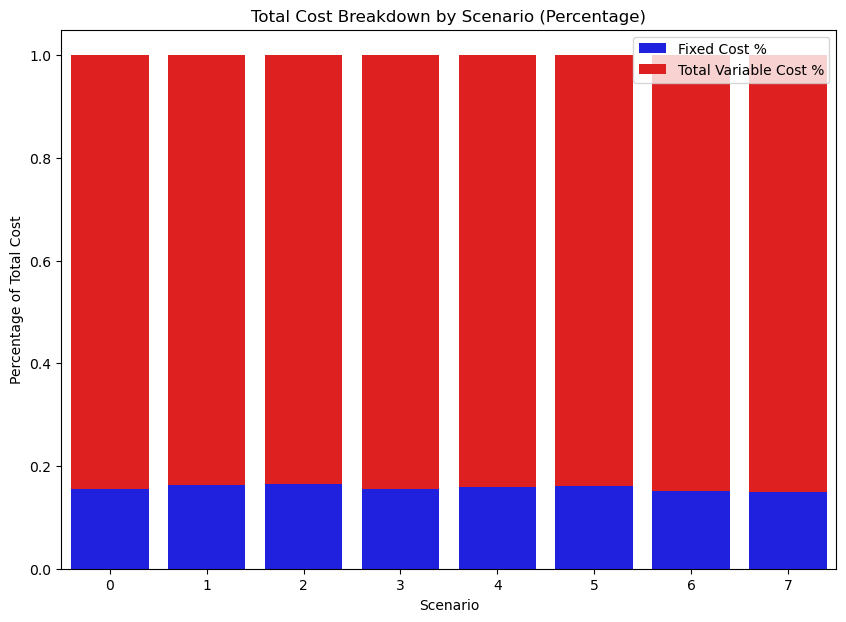

In [34]:
# Now, let's plot the stacked bar chart using percentages
plt.figure(figsize=(10, 7))
sns.barplot(data=costs, x='Scenario', y='% FC', color='b', label='Fixed Cost %')
sns.barplot(data=costs, x='Scenario', y='% VC', color='r', label='Total Variable Cost %', bottom=costs['% FC'])

# Add some labels and a legend
plt.title('Total Cost Breakdown by Scenario (Percentage)')
plt.ylabel('Percentage of Total Cost')
plt.xlabel('Scenario')
plt.legend(loc='upper right')

# Show the plot
plt.show()

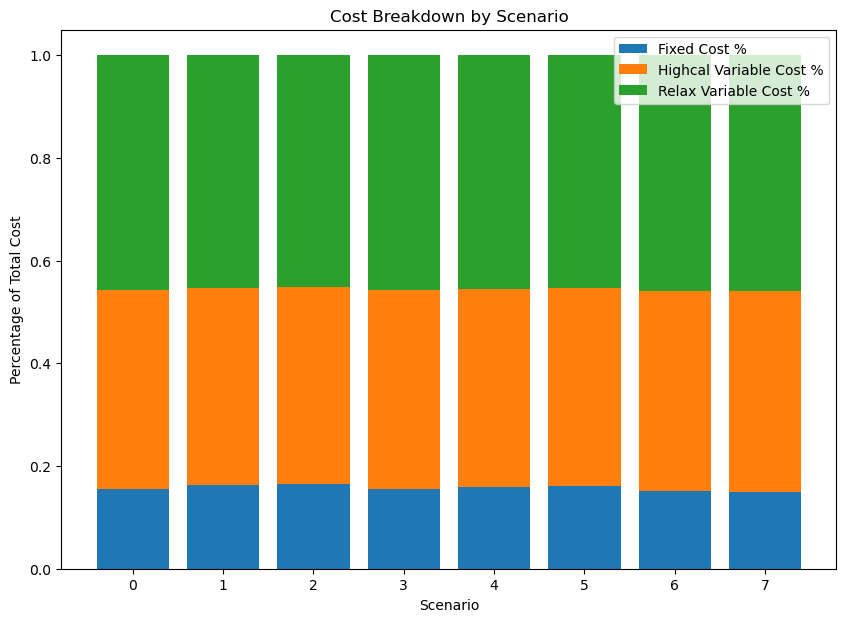

In [35]:
# Plot the stacks
plt.figure(figsize=(10, 7))

# Define the bottom for the second and third stack
bottom_hvc = costs['% FC']
bottom_rvc = costs['% FC'] + costs['% HVC']

plt.bar(costs['Scenario'], costs['% FC'], label='Fixed Cost %')
plt.bar(costs['Scenario'], costs['% HVC'], bottom=bottom_hvc, label='Highcal Variable Cost %')
plt.bar(costs['Scenario'], costs['% RVC'], bottom=bottom_rvc, label='Relax Variable Cost %')

plt.title('Cost Breakdown by Scenario')
plt.xlabel('Scenario')
plt.ylabel('Percentage of Total Cost')
plt.legend()

plt.show()

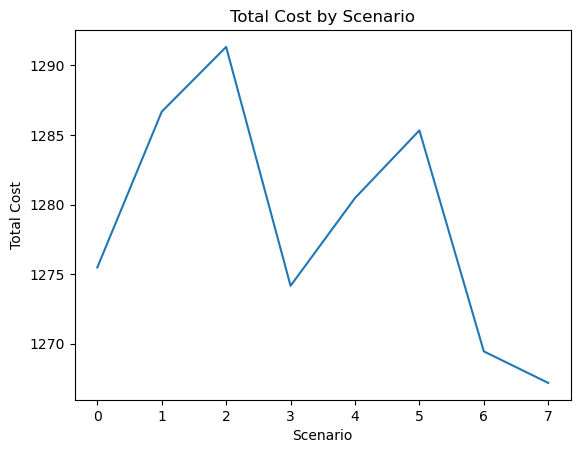

In [36]:
# plot the costs by each scenario
ax = sns.lineplot(data=costs, x='Scenario', y='Total Cost')
ax.set_title("Total Cost by Scenario");

In [37]:
plants = ['Brazil', 'Germany', 'India','Japan', 'Mexico', 'US']
sol_y = []
sol_h = []
sol_r = []
for i in range(0, n):
    sol_y.append(y[i].varValue)
    sol_h.append(h[i].varValue)
    sol_r.append(r[i].varValue)

open_plants = pd.DataFrame({'Plant': plants, 'Open/Close': sol_y, 'Produce HighCal': sol_h, 'Produce Relax': sol_r})
open_plants

,Plant,Open/Close,Produce HighCal,Produce Relax
0,Brazil,1.0,1.0,1.0
1,Germany,1.0,0.0,1.0
2,India,1.0,1.0,1.0
3,Japan,0.0,0.0,0.0
4,Mexico,1.0,1.0,1.0
5,US,1.0,1.0,1.0


In [38]:
Solution_highcal = []
for i in range(0,n):
        Solution_highcal.append({'Latin America': x[(i,0,1)].varValue,
                         'Europe': x[(i,1,1)].varValue,
                         'Asia w/o Japan': x[(i,2,1)].varValue,
                         'Japan': x[(i,3,1)].varValue,
                         'Mexico': x[(i,4,1)].varValue,
                         'U.S.': x[(i,5,1)].varValue})

Solution_relax = []
for i in range(0,n):
        Solution_relax.append({'Latin America': x[(i,0,2)].varValue,
                         'Europe': x[(i,1,2)].varValue,
                         'Asia w/o Japan': x[(i,2,2)].varValue,
                         'Japan': x[(i,3,2)].varValue,
                         'Mexico': x[(i,4,2)].varValue,
                         'U.S.': x[(i,5,2)].varValue})
        
        
quantity_highcal = pd.DataFrame(Solution_highcal)
quantity_highcal.insert(0, "From\To", ['Brazil', 'Germany', 'India','Japan', 'Mexico', 'US'])

quantity_relax = pd.DataFrame(Solution_relax)
quantity_relax.insert(0, "From\To", ['Brazil', 'Germany', 'India','Japan', 'Mexico', 'US'])


print("Optimal Highcal Quantity (Million Kilograms):")
display(quantity_highcal)

print("Optimal Relax Quantity (Million Kilograms):")
display(quantity_relax)

Optimal Highcal Quantity (Million Kilograms):


,From\To,Latin America,Europe,Asia w/o Japan,Japan,Mexico,U.S.
0,Brazil,7.0,4.0,0.0,0.0,0.0,0.0
1,Germany,0.0,0.0,0.0,0.0,0.0,0.0
2,India,0.0,0.0,5.0,7.0,0.0,0.0
3,Japan,0.0,0.0,0.0,0.0,0.0,0.0
4,Mexico,0.0,11.0,0.0,0.0,3.0,13.0
5,US,0.0,0.0,0.0,0.0,0.0,5.0


Optimal Relax Quantity (Million Kilograms):


,From\To,Latin America,Europe,Asia w/o Japan,Japan,Mexico,U.S.
0,Brazil,7.0,0.0,0.0,0.0,0.0,0.0
1,Germany,0.0,12.0,0.0,5.0,0.0,0.0
2,India,0.0,0.0,3.0,3.0,0.0,0.0
3,Japan,0.0,0.0,0.0,0.0,0.0,0.0
4,Mexico,0.0,0.0,0.0,0.0,3.0,0.0
5,US,0.0,0.0,0.0,0.0,0.0,17.0
